# Préparation des données, nettoyage et analyse exploratoire
Ce notebook présente les étapes de préparation des données, nettoyage et analyse exploratoire pour le projet de classification de billets de banque.
# Sommaire
1. [Importation des librairies](#1.-Importation-des-librairies)
2. [Importation des données](#2.-Importation-des-données)
3. [Exploration des données](#3.-Exploration-des-données)
4. [Préparation des données](#4.-Préparation-des-données)
5. [Modélisation](#5.-Modélisation)


# 1. Importation des librairies

In [143]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import shapiro
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.cluster import KMeans

# 2. Importation des données

In [144]:
# Importation des données
data = pd.read_csv('billets.csv', sep=';', decimal='.')

In [145]:
# Affichage des 5 premières lignes
data.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

# 3. Exploration des données
## Objectif
- Comprendre du mieux possible les données
- Développer une première stratégie de modélisation

**Variable cible** : `is_genuine`


## Analyse de la forme des données

In [146]:
# Copie des données
df_eda = data.copy()

### Nombre de lignes et de colonnes

In [147]:
# Nombre de lignes et de colonnes
df_eda.shape

(1500, 7)

### Types de variables

In [148]:
# Types de variables
df_eda.dtypes.value_counts()

float64    6
bool       1
dtype: int64

### Analyse des valeurs manquantes

In [149]:
# Nombre de valeurs manquantes par variable
df_eda.isna().sum().sort_values(ascending=False)#

margin_low      37
is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_up        0
length           0
dtype: int64

In [150]:
# Pourcentage de valeurs manquantes par variable
(df_eda.isna().sum()/df_eda.shape[0]).sort_values(ascending=False)

margin_low      0.024667
is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_up       0.000000
length          0.000000
dtype: float64

On a 37 valeurs manquantes sur la variable `margin_low`, soit 2.5% des données. On peut les supprimer sans risque ou trouver leurs valeurs avec une régression linéaire. On choisit de trouver leurs valeurs avec une régression linéaire.

## Analyse de fond des données
### Visualisation de la target


In [151]:
# Visualisation de la target
df_eda['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [152]:
# Visualisation de la target en pourcentage
df_eda['is_genuine'].value_counts(normalize=True)

True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

Il y a 1000 billets authentiques et 500 billets falsifiés (soit 33%). les données ne sont pas équilibrées.

### Histogramme des variables continues
Les histogrammes des variables continues nous permettent de visualiser la distribution des variables.

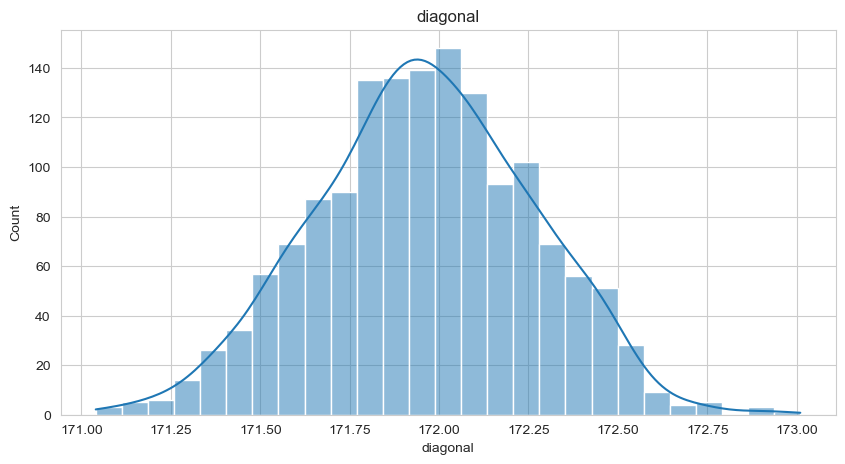

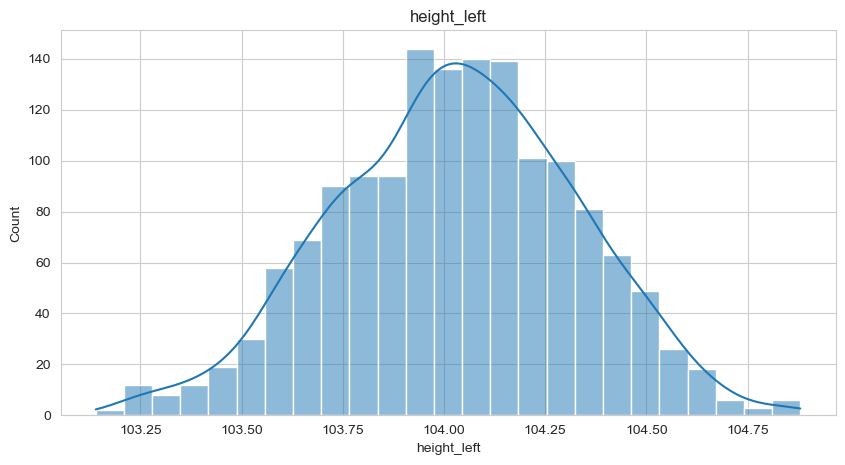

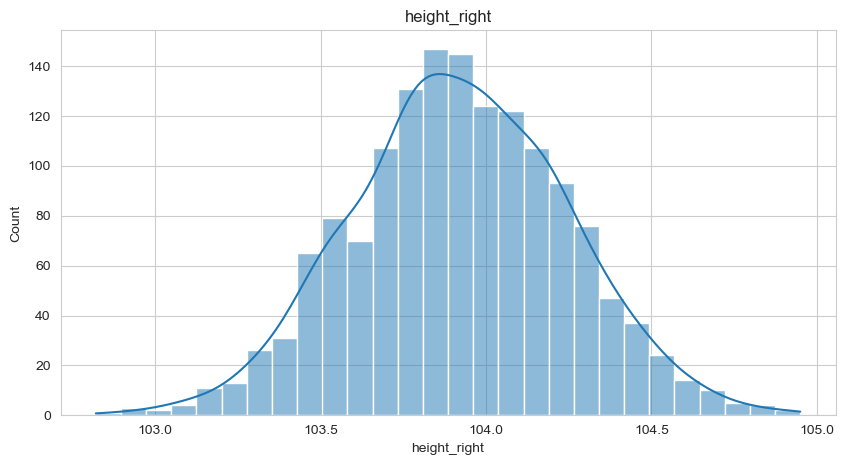

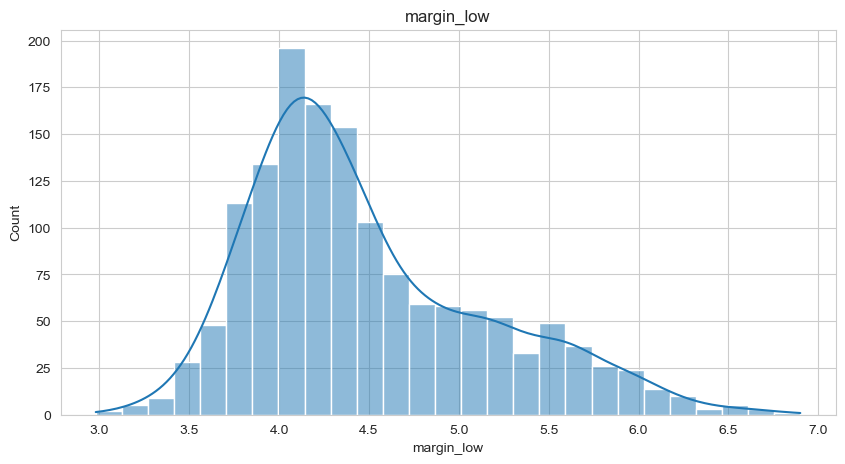

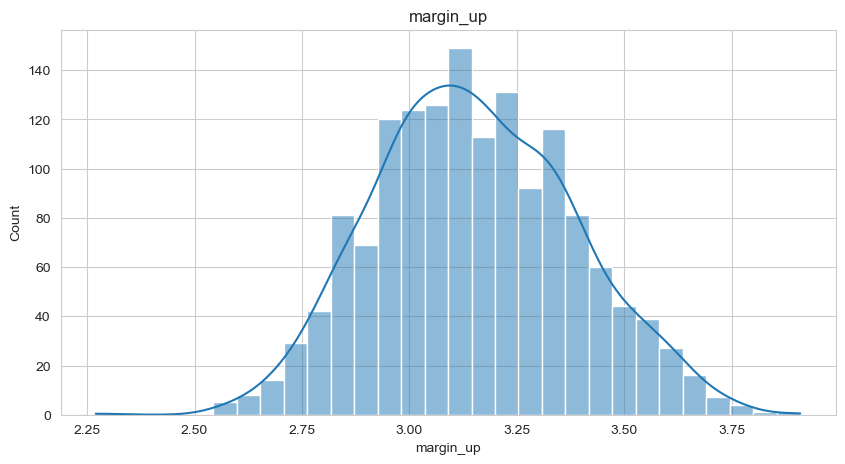

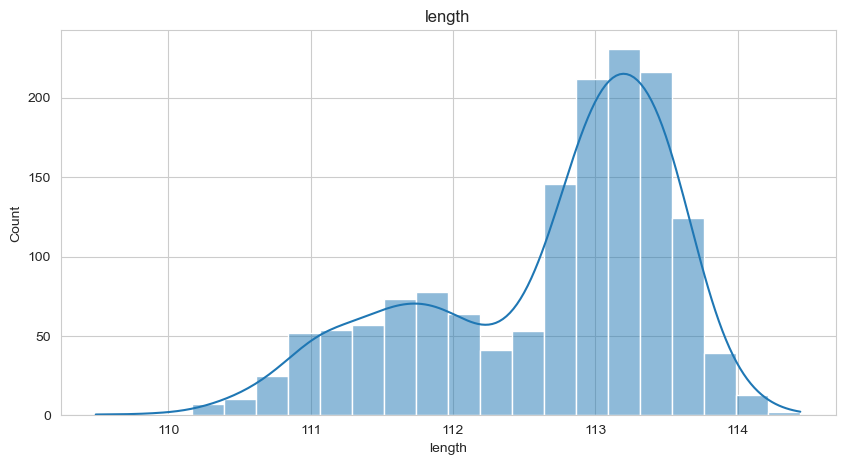

In [153]:
# Histogramme des variables continues
for col in df_eda.select_dtypes('float64'):
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_eda, x=col, kde=True)
    plt.title(col)
    plt.show()

Les variables sont des mesures de la forme du billet. Les variables `margin_low` et `margin_up` sont des mesures de la marge du billet. La variable `diagonal` est la diagonale du billet. La variable `length` est la longueur du billet. La variable `height` est la hauteur du billet. La plupart des variables suivent une distribution normale, sauf pour les variables `margin_low` et `length` qui sont asymétriques.

## Relation Variables / Target
### Creation de sous-ensembles True et False
Les sous-ensembles True et False vont nous permettre de visualiser les relations entre les variables et la target.

In [154]:
# Création d'un sous-ensemble True
true_df_eda = df_eda[df_eda['is_genuine'] == True]

In [155]:
# Création d'un sous-ensemble False
false_df_eda = df_eda[df_eda['is_genuine'] == False]

### Visualisation des relations Variables / Target
Les histogrammes des variables par rapport à la target nous permettent de visualiser les relations entre les variables et la target.

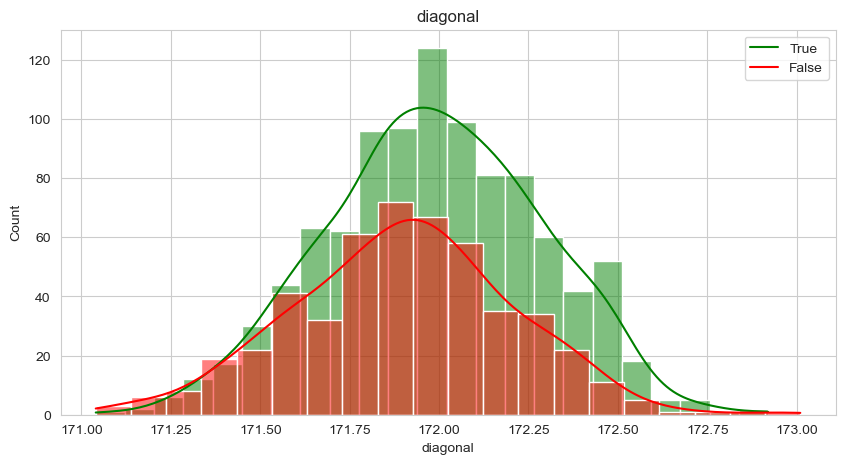

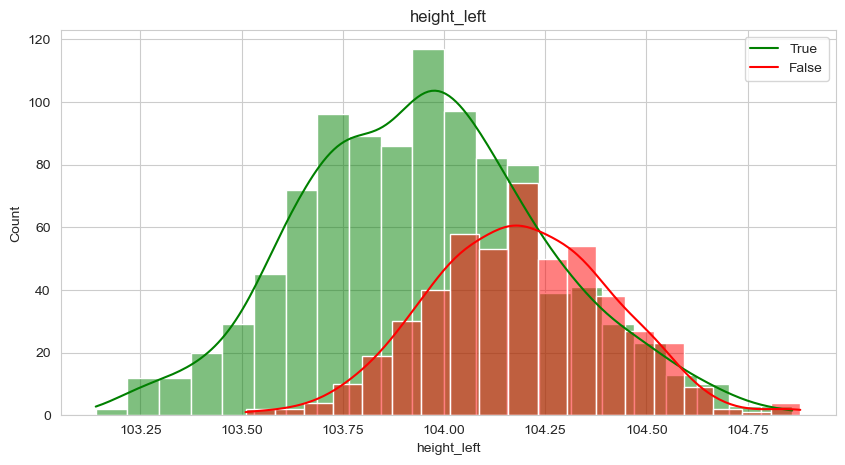

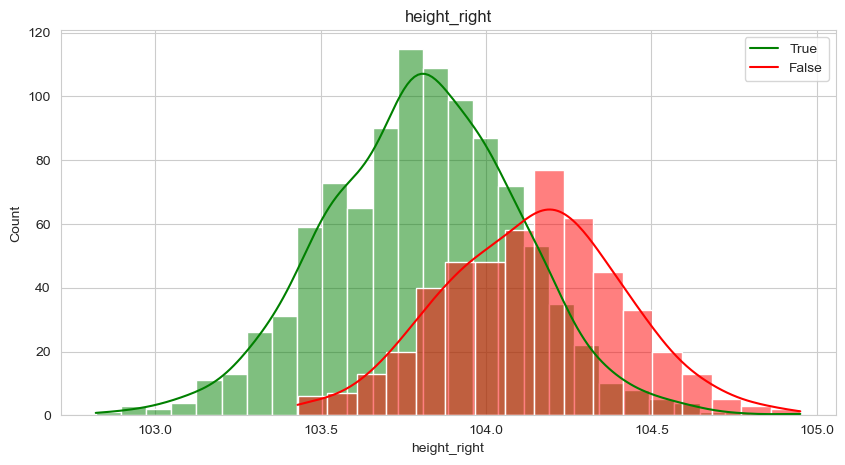

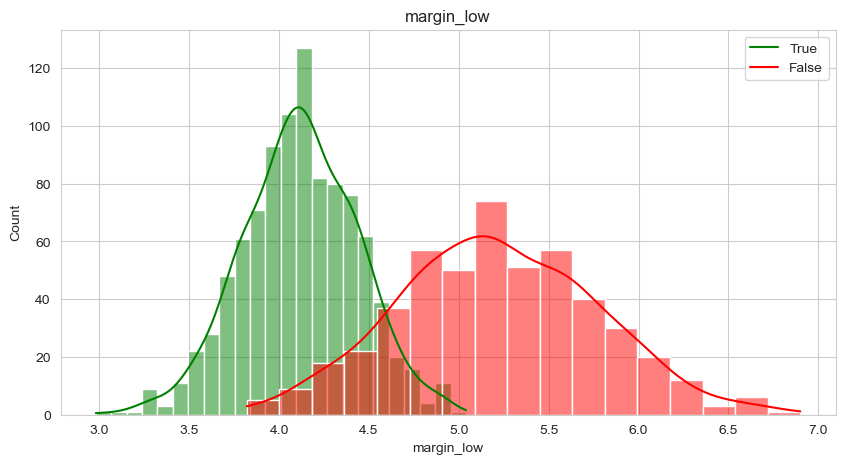

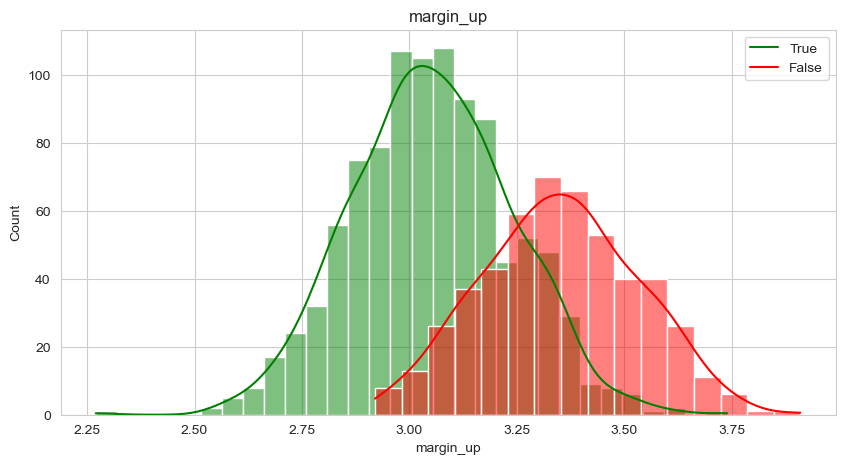

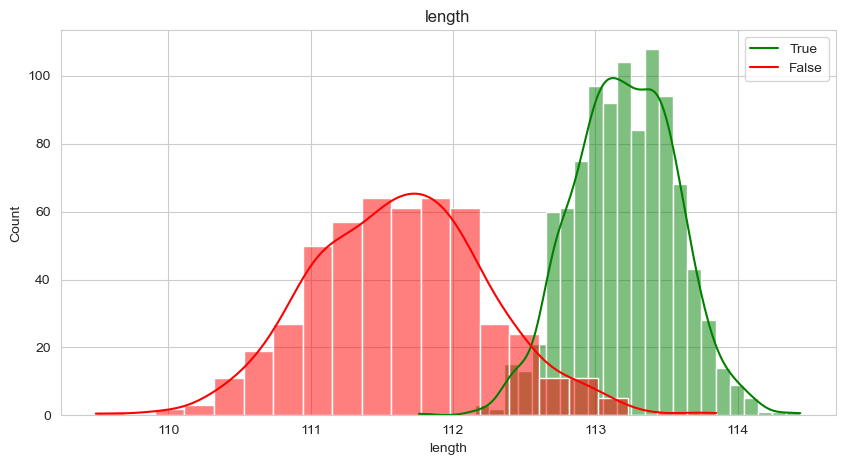

In [156]:
# Visualisation de la target dans les sous-ensembles
for col in df_eda.select_dtypes('float64'):
    plt.figure(figsize=(10, 5))
    sns.histplot(data=true_df_eda, x=col, kde=True, color='green')
    sns.histplot(data=false_df_eda, x=col, kde=True, color='red')
    plt.legend(['True', 'False'])
    plt.title(col)
    plt.show()


Il semblerait que les variables `margin_low` et `length` soient les plus discriminantes. Les billets authentiques ont des valeurs moins élevées pour la variable `margin_low` et plus élevées pour la variable `length` que les billets falsifiés. Hypothèse à vérifier.

### Conclusions initiales
- Les données sont assez propres, il n'y a pas de valeurs aberrantes.
- Il y a peu de valeurs manquantes, on peut les supprimer sans risque ou les calculer avec une régression linéaire.
- Les données ne sont pas équilibrées, il faudra utiliser une métrique adaptée.
- Les variables `margin_low` et `length` semblent être les plus discriminantes.
- Il faudra vérifier nos hypothèses.

## Analyse plus détaillée
### Relation Variables / Variables

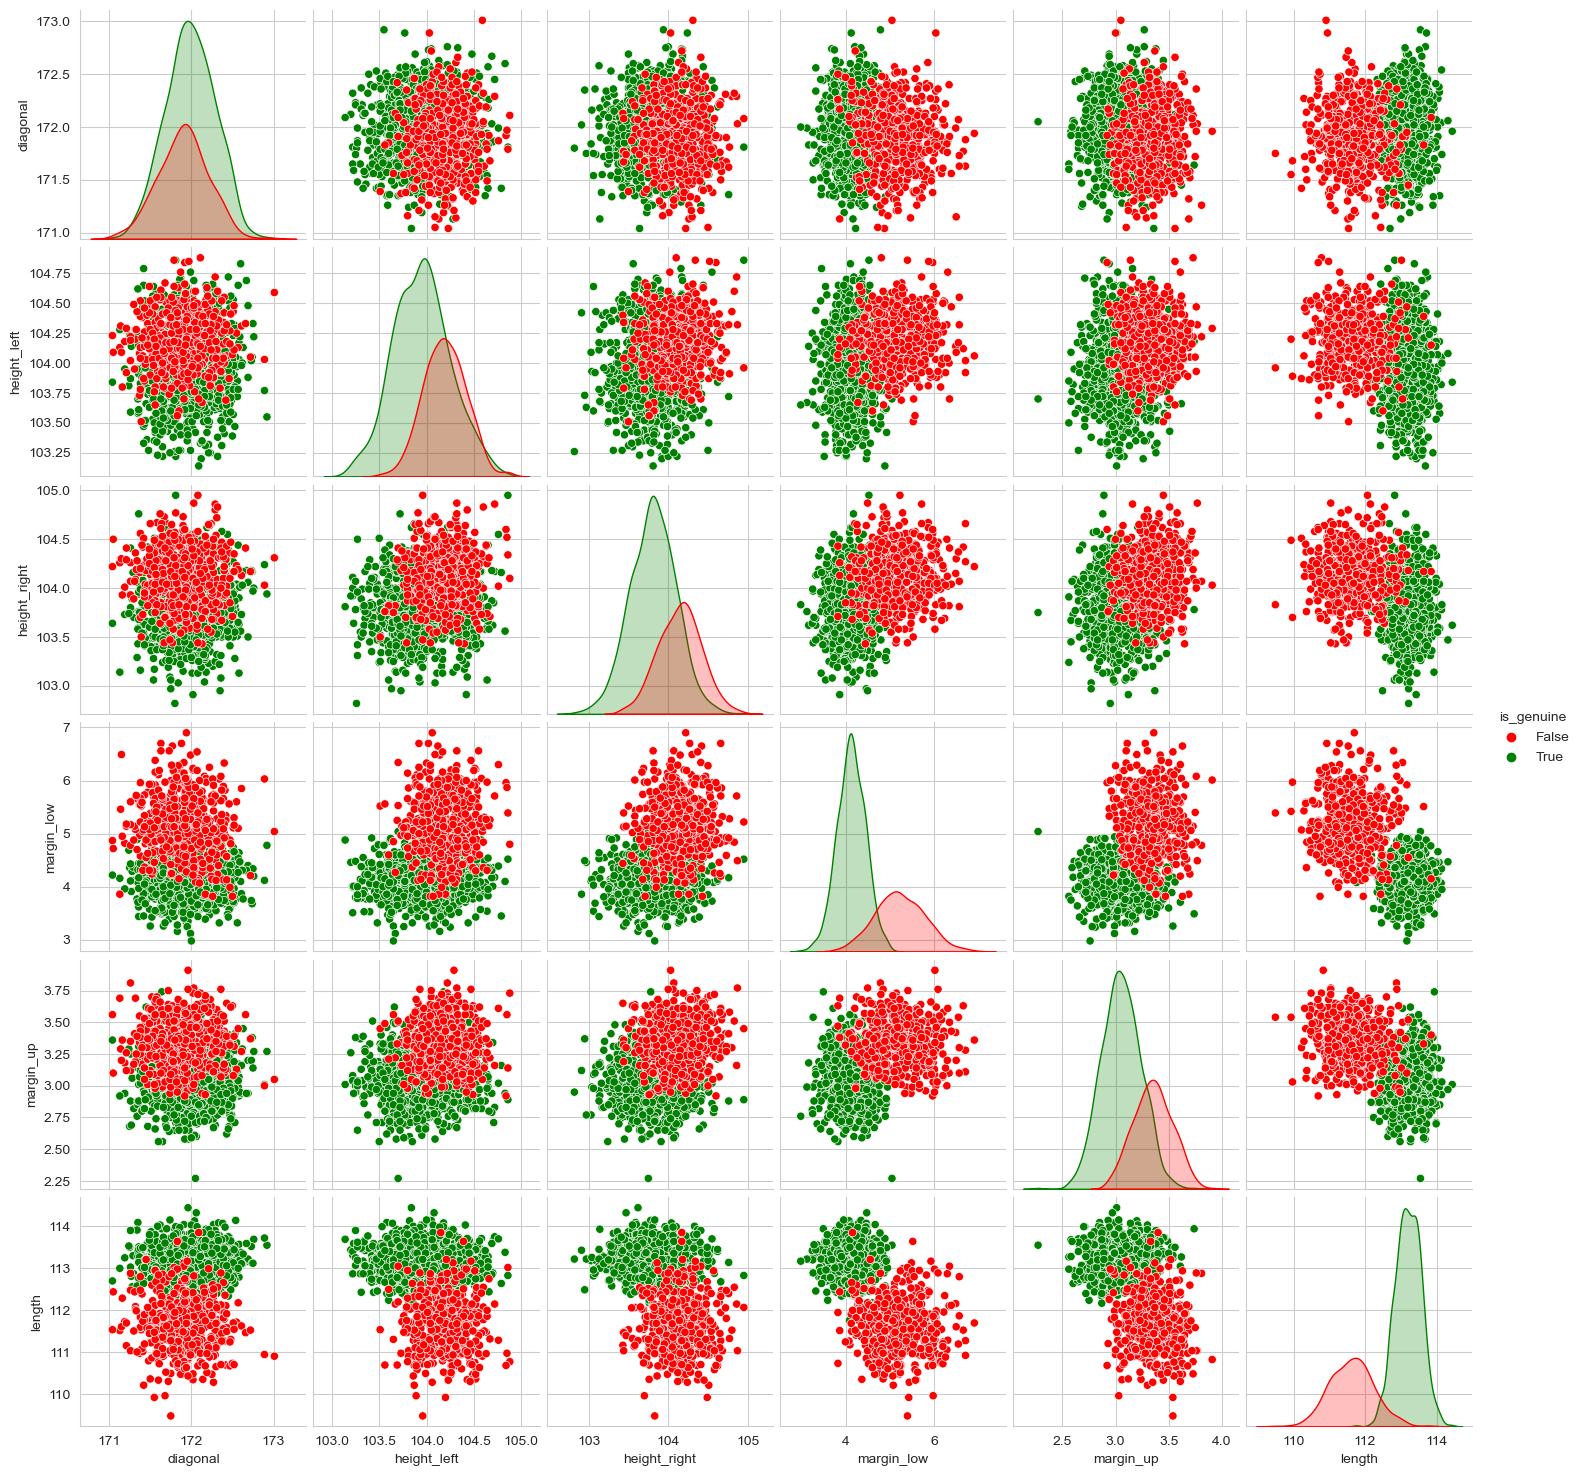

In [157]:
# Visualisation des relations Variables / Variables
custom_palette = {True: 'green', False: 'red'}
sns.pairplot(df_eda, hue='is_genuine', palette=custom_palette)


Les variables `margin_low` et `length` semblent être les plus discriminantes. Les billets authentiques ont des valeurs moins élevées pour la variable `margin_low` et plus élevées pour la variable `length` que les billets falsifiés. Hypothèse à vérifier.

<AxesSubplot:>

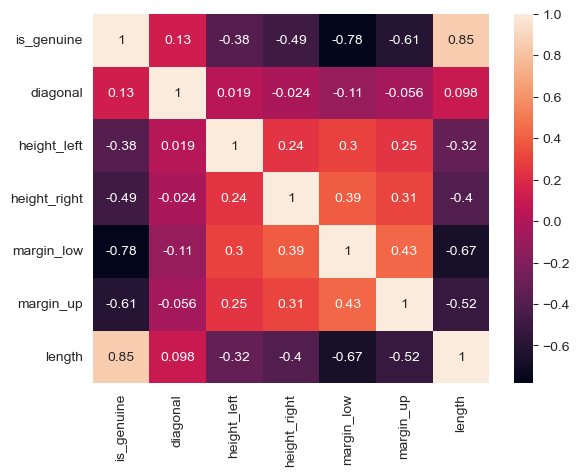

In [158]:
# Matrice de corrélation
sns.heatmap(df_eda.corr(), annot=True)

In [159]:
# Matrice de corrélation avec la target
df_eda.corr()['is_genuine'].sort_values(ascending=False)

is_genuine      1.000000
length          0.849285
diagonal        0.132756
height_left    -0.379833
height_right   -0.485092
margin_up      -0.606262
margin_low     -0.783032
Name: is_genuine, dtype: float64

In [160]:
# Matrice de corrélation avec la variable margin_low
df_eda.corr()['margin_low'].sort_values(ascending=False)

margin_low      1.000000
margin_up       0.431606
height_right    0.391085
height_left     0.302643
diagonal       -0.111534
length         -0.666753
is_genuine     -0.783032
Name: margin_low, dtype: float64

- Les variables `margin_low` et `length` sont fortement corrélées avec la target.
- Les variables `margin_low` et `length` sont fortement inversement corrélées entre elles. On pourra l'utiliser pour retrouver les valeurs manquantes.

### Valeurs manquantes

In [161]:
# affichage des valeurs manquantes
df_eda[df_eda['margin_low'].isna()]

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72          True    171.94       103.89        103.45         NaN       3.25   
99          True    171.93       104.07        104.18         NaN       3.14   
151         True    172.07       103.80        104.38         NaN       3.02   
197         True    171.45       103.66        103.80         NaN       3.62   
241         True    171.83       104.14        104.06         NaN       3.02   
251         True    171.80       103.26        102.82         NaN       2.95   
284         True    171.92       103.83        103.76         NaN       3.23   
334         True    171.85       103.70        103.96         NaN       3.00   
410         True    172.56       103.72        103.51         NaN       3.12   
413         True    172.30       103.66        103.50         NaN       3.16   
445         True    172.34       104.42        103.22         NaN       3.01   
481         True    171.81       103.53        103.96         NaN       2.71   
505         True    172.01       103.97        104.05         NaN       2.98   
611         True    171.80       103.68        103.49         NaN       3.30   
654         True    171.97       103.69        103.54         NaN       2.70   
675         True    171.60       103.85        103.91         NaN       2.56   
710         True    172.03       103.97        103.86         NaN       3.07   
739         True    172.07       103.74        103.76         NaN       3.09   
742         True    172.14       104.06        103.96         NaN       3.24   
780         True    172.41       103.95        103.79         NaN       3.13   
798         True    171.96       103.84        103.62         NaN       3.01   
844         True    171.62       104.14        104.49         NaN       2.99   
845         True    172.02       104.21        104.05         NaN       2.90   
871         True    171.37       104.07        103.75         NaN       3.07   
895         True    171.81       103.68        103.80         NaN       2.98   
919         True    171.92       103.68        103.45         NaN       2.58   
945         True    172.09       103.74        103.52         NaN       3.02   
946         True    171.63       103.87        104.66         NaN       3.27   
981         True    172.02       104.23        103.72         NaN       2.99   
1076       False    171.57       104.27        104.44         NaN       3.21   
1121       False    171.40       104.38        104.19         NaN       3.17   
1176       False    171.59       104.05        103.94         NaN       3.02   
1303       False    172.17       104.49        103.76         NaN       2.93   
1315       False    172.08       104.15        104.17         NaN       3.40   
1347       False    171.72       104.46        104.12         NaN       3.61   
1435       False    172.66       104.33        104.41         NaN       3.56   
1438       False    171.90       104.28        104.29         NaN       3.24   

      length  
72    112.79  
99    113.08  
151   112.93  
197   113.27  
241   112.36  
251   113.22  
284   113.29  
334   113.36  
410   112.95  
413   112.95  
445   112.97  
481   113.99  
505   113.65  
611   112.84  
654   112.79  
675   113.27  
710   112.65  
739   112.41  
742   113.07  
780   113.41  
798   114.44  
844   113.35  
845   113.62  
871   113.27  
895   113.82  
919   113.68  
945   112.78  
946   112.68  
981   113.37  
1076  111.87  
1121  112.39  
1176  111.29  
1303  111.21  
1315  112.29  
1347  110.31  
1435  111.47  
1438  111.49

In [162]:
# pourcentage des faux billets
df_eda['is_genuine'].value_counts(normalize=True)

True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

In [163]:
# pourcentage des faux billets sans les valeurs manquantes
df_eda.dropna()['is_genuine'].value_counts(normalize=True)

True     0.663705
False    0.336295
Name: is_genuine, dtype: float64

Si l'on supprime les valeurs manquantes, on garde à peu près les mêmes proportions de billets authentiques et falsifiés.

## T-Test
- Les variables `margin_low` et `length` sont-elles discriminantes ?
    - H0 = les valeurs moyenne de la variable `margin_low`  sont les mêmes pour les billets authentiques et falsifiés.
    - H0 = les valeurs moyenne de la variable `length` sont les mêmes pour les billets authentiques et falsifiés

In [164]:
# nombre de billets authentiques
true_df_eda.shape[0]

1000

In [165]:
# nombre de billets falsifiés
false_df_eda.shape[0]

500

In [166]:
# sous-ensemble de billets authentiques équilibré
balanced_true = true_df_eda.sample(false_df_eda.shape[0])

In [167]:
# T-Test
def t_test(col):
    alpha = 0.05
    stat, p = ttest_ind(balanced_true[col].dropna(), false_df_eda[col].dropna())
    if p < alpha:
        return 'H0 rejetée'
    else:
        return 'H0 non rejetée'


In [168]:
# boucle sur les variables
for col in df_eda.select_dtypes('float64'):
    print(f'{col :-<20} {t_test(col)}')

diagonal------------ H0 rejetée
height_left--------- H0 rejetée
height_right-------- H0 rejetée
margin_low---------- H0 rejetée
margin_up----------- H0 rejetée
length-------------- H0 rejetée


Les hypothèses sont rejetées, les variables `margin_low` et `length` sont discriminantes, ainsi que toutes les autres variables.

# 4. Préparation des données
## Test pour régression linéaire
On va utiliser une régression linéaire pour calculer les valeurs manquantes de la variable `margin_low`.
### Test de normalité
On effectue un test de normalité sur les variables `margin_low` et `length` pour vérifier si on peut utiliser une régression linéaire pour calculer les valeurs manquantes.

Les variables `margin_low` et `length` sont-elles normalement distribuées ?
- H0 = la distribution est normale
- H1 = la distribution n'est pas normale

H0 est rejetée si p < 0.05

In [169]:
# Fonction de test de normalité
def test_normal(df, columns):
    result_test = pd.DataFrame(columns=['variable','stat', 'p', 'normalité'])

    for col in columns:
        # Calculer le test de normalité pour la colonne en cours
        stat, p = shapiro(df[col].dropna())

        # Ajouter les résultats au DataFrame de résultats
        new_row = pd.DataFrame({
            'variable': [col],
            'stat': [stat],
            'p': [p],
            'normalité': [p > 0.05]})

        result_test = pd.concat([result_test, new_row], ignore_index=True)

    return result_test


In [170]:
# test de normalité sur les variables margin_low, margin_up et length
test_normal(df_eda, ['margin_low', 'length', 'margin_up'])

variable      stat             p normalité
0  margin_low  0.937784  2.828388e-24     False
1      length  0.917601  7.863947e-28     False
2   margin_up  0.996166  8.104062e-04     False

#### Test d'homoscédasticité
Le test d'homoscédasticité permet de vérifier si les variances des résidus sont constantes par rapport à la variable explicative.

In [171]:
# fonction de test d'homoscédasticité
def test_homoscedasticity(df, col1, col2):
    x = sm.add_constant(df[[col1]])
    y = df[col2]

    # Créer un modèle de régression linéaire
    model = sm.OLS(y, x).fit()

    # Calculer le test de Breusch-Pagan
    bp_test = het_breuschpagan(model.resid, x)

    # Afficher les résultats
    results_test = pd.DataFrame(columns=['stat', 'p', 'stat_lm', 'p_lm', 'hétéroscédasticité'])
    new_row = pd.DataFrame({
        'stat': [bp_test[0]],
        'p': [bp_test[1]],
        'stat_lm': [bp_test[2]],
        'p_lm': [bp_test[3]],
        'hétéroscédasticité': [bp_test[1] < 0.05]})
    results_test = pd.concat([results_test, new_row], ignore_index=True)

    return results_test

In [172]:
# test d'homoscédasticité sur les variables margin_low et length
df_clean = df_eda.dropna(subset=['margin_low', 'length'])
test_homoscedasticity(df_clean, 'length', 'margin_low')

stat             p    stat_lm          p_lm hétéroscédasticité
0  60.902737  5.996541e-15  63.461289  3.263714e-15               True

#### Test de multicollinéarité
le test de multicollinéarité permet de vérifier si les variables explicatives sont corrélées entre elles.

In [173]:
# test de multicolinéarité
def test_multicollinearity(df, col):

    x = df[col].dropna()

    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    vif["features"] = x.columns

    print(vif)


In [174]:
test_multicollinearity(df_clean, ['margin_low', 'length', 'margin_up', 'diagonal', 'height_left', 'height_right'])

      VIF Factor      features
0      89.003990    margin_low
1   31205.638468        length
2     264.908266     margin_up
3  170808.246898      diagonal
4  114373.426488   height_left
5  105157.499668  height_right


#### Conclusion
Les tests ne sont pas concluants pour faire une régression linzéaire sur les variables `margin_low` et `length`.
On va utiliser la fonction PolynomialFeatures de sklearn pour créer des variables polynomiales.

## Régression linaire simple
Même si les tests ne sont pas concluants, on va quand même essayer de faire une régression linéaire simple sur les variables `margin_low` et `length`. On compare les résultats avec une régression linéaire polynomiale.


In [175]:
# Supprimer les valeurs manquantes
df_clean = df_eda.dropna(axis=0)

In [176]:
# Créer les variables X et y
y = df_clean['margin_low'].values
y = y.reshape(y.shape[0], 1)
x = df_clean['length'].values
x = x.reshape(x.shape[0], 1)
print(y.shape)
print(x.shape)


(1463, 1)
(1463, 1)


In [177]:
# Créer le modèle de régression linéaire et l'entraîner
model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [178]:
# Afficher les coefficients
predictions = model.predict(x)

In [179]:
# Indicateur de performance R2, RMSE et MAE
r2_regression_simple = model.score(x, y)
print("R2: %f" % r2_regression_simple)
rmse_regression_simple = np.sqrt(mean_squared_error(y, model.predict(x)))
print("RMSE: %f" % rmse_regression_simple)
mae_regression_simple = mean_absolute_error(y, model.predict(x))
print("MAE: %f" % mae_regression_simple)


R2: 0.444559
RMSE: 0.494556
MAE: 0.383227


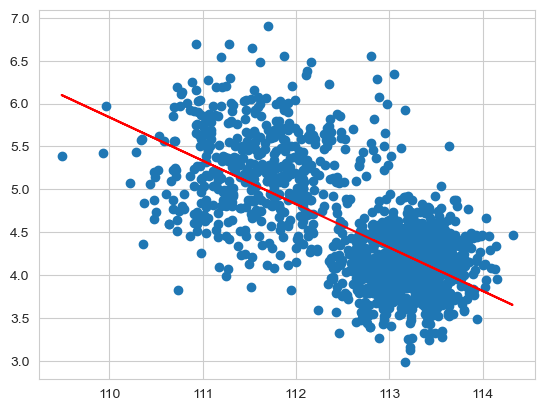

In [180]:
# Afficher les résultats
plt.scatter(x,y)
plt.plot(x, predictions, c= 'r')

## Régression linéaire polynomiale
On va maintenant utiliser la fonction PolynomialFeatures de sklearn pour créer des variables polynomiales.

In [181]:
# Créer les variables X et y
x = df_clean.drop(columns=['margin_low','is_genuine']).values
y = df_clean['margin_low'].values

In [182]:
# Créer le modèle de régression linéaire et l'entraîner
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(x)
model = LinearRegression()
model.fit(X_poly, y)



LinearRegression()

In [183]:
# Indicateur de performance R2, RMSE et MAE
r2_regression_poly = model.score(X_poly, y)
print("R2: %f" % r2_regression_poly)
rmse_regression_poly = np.sqrt(mean_squared_error(y, model.predict(X_poly)))
print("RMSE: %f" % rmse_regression_poly)
mae_regression_poly = mean_absolute_error(y, model.predict(X_poly))
print("MAE: %f" % mae_regression_poly)


R2: 0.613893
RMSE: 0.412336
MAE: 0.318468


### Conclusion
Pour rappel, les indicateurs de performance des deux régressions sont:

In [184]:
# Indicateur de performance R2, RMSE et MAE
print("Indicateurs de performance de la régression linéaire simple")
print("R2: %f" % r2_regression_simple)
print("RMSE: %f" % rmse_regression_simple)
print("MAE: %f" % mae_regression_simple)
print("Indicateurs de performance de la régression linéaire polynomiale")
print("R2: %f" % r2_regression_poly)
print("RMSE: %f" % rmse_regression_poly)
print("MAE: %f" % mae_regression_poly)

Indicateurs de performance de la régression linéaire simple
R2: 0.444559
RMSE: 0.494556
MAE: 0.383227
Indicateurs de performance de la régression linéaire polynomiale
R2: 0.613893
RMSE: 0.412336
MAE: 0.318468


On peut voir que le modèle de régression linéaire polynomiale est meilleur que le modèle de régression linéaire simple. Il a un meilleur R2 et les valeurs de RMSE et MAE sont plus faibles. On va donc utiliser le modèle de régression linéaire polynomiale pour prédire les valeurs manquantes de la variable `margin_low`.

## Prédiction des valeurs manquantes

In [185]:
# Prédire les valeurs manquantes
X_predict = df_eda[df_eda.isnull().any(axis=1)].drop(columns=['margin_low','is_genuine']).values
X_poly_predict = poly.fit_transform(X_predict)
model.predict(X_poly_predict)

array([4.10498575, 4.34613565, 4.20660928, 4.66034463, 4.78308633,
       5.37317422, 4.10843423, 4.16217569, 3.84381631, 3.86346963,
       4.1672416 , 4.98965982, 4.13660196, 4.08069375, 3.92407754,
       4.2295585 , 4.35376504, 4.35632852, 4.26605752, 4.10962442,
       3.9684501 , 3.76569131, 4.13165811, 3.97031167, 4.11435464,
       4.73187784, 4.00931314, 4.9281669 , 3.97528604, 5.3054252 ,
       4.96472696, 5.78430703, 4.9316459 , 4.91461709, 4.37671426,
       4.52441934, 5.29736856])

In [186]:
# Créer un nouveau dataframe avec les valeurs prédites
df_avec_prediction = df_eda.copy()

df_avec_prediction['prediction'] = 'Origine'
df_avec_prediction.loc[df_avec_prediction.isnull().any(axis=1), 'prediction'] = 'Prédiction'

In [187]:
# Remplacer les valeurs manquantes par les valeurs prédites
df_avec_prediction.loc[df_avec_prediction.isnull().any(axis=1), 'margin_low']= model.predict(X_poly_predict)
df_avec_prediction[df_avec_prediction['prediction'] == 'Prédiction']

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72          True    171.94       103.89        103.45    4.104986       3.25   
99          True    171.93       104.07        104.18    4.346136       3.14   
151         True    172.07       103.80        104.38    4.206609       3.02   
197         True    171.45       103.66        103.80    4.660345       3.62   
241         True    171.83       104.14        104.06    4.783086       3.02   
251         True    171.80       103.26        102.82    5.373174       2.95   
284         True    171.92       103.83        103.76    4.108434       3.23   
334         True    171.85       103.70        103.96    4.162176       3.00   
410         True    172.56       103.72        103.51    3.843816       3.12   
413         True    172.30       103.66        103.50    3.863470       3.16   
445         True    172.34       104.42        103.22    4.167242       3.01   
481         True    171.81       103.53        103.96    4.989660       2.71   
505         True    172.01       103.97        104.05    4.136602       2.98   
611         True    171.80       103.68        103.49    4.080694       3.30   
654         True    171.97       103.69        103.54    3.924078       2.70   
675         True    171.60       103.85        103.91    4.229558       2.56   
710         True    172.03       103.97        103.86    4.353765       3.07   
739         True    172.07       103.74        103.76    4.356329       3.09   
742         True    172.14       104.06        103.96    4.266058       3.24   
780         True    172.41       103.95        103.79    4.109624       3.13   
798         True    171.96       103.84        103.62    3.968450       3.01   
844         True    171.62       104.14        104.49    3.765691       2.99   
845         True    172.02       104.21        104.05    4.131658       2.90   
871         True    171.37       104.07        103.75    3.970312       3.07   
895         True    171.81       103.68        103.80    4.114355       2.98   
919         True    171.92       103.68        103.45    4.731878       2.58   
945         True    172.09       103.74        103.52    4.009313       3.02   
946         True    171.63       103.87        104.66    4.928167       3.27   
981         True    172.02       104.23        103.72    3.975286       2.99   
1076       False    171.57       104.27        104.44    5.305425       3.21   
1121       False    171.40       104.38        104.19    4.964727       3.17   
1176       False    171.59       104.05        103.94    5.784307       3.02   
1303       False    172.17       104.49        103.76    4.931646       2.93   
1315       False    172.08       104.15        104.17    4.914617       3.40   
1347       False    171.72       104.46        104.12    4.376714       3.61   
1435       False    172.66       104.33        104.41    4.524419       3.56   
1438       False    171.90       104.28        104.29    5.297369       3.24   

      length  prediction  
72    112.79  Prédiction  
99    113.08  Prédiction  
151   112.93  Prédiction  
197   113.27  Prédiction  
241   112.36  Prédiction  
251   113.22  Prédiction  
284   113.29  Prédiction  
334   113.36  Prédiction  
410   112.95  Prédiction  
413   112.95  Prédiction  
445   112.97  Prédiction  
481   113.99  Prédiction  
505   113.65  Prédiction  
611   112.84  Prédiction  
654   112.79  Prédiction  
675   113.27  Prédiction  
710   112.65  Prédiction  
739   112.41  Prédiction  
742   113.07  Prédiction  
780   113.41  Prédiction  
798   114.44  Prédiction  
844   113.35  Prédiction  
845   113.62  Prédiction  
871   113.27  Prédiction  
895   113.82  Prédiction  
919   113.68  Prédiction  
945   112.78  Prédiction  
946   112.68  Prédiction  
981   113.37  Prédiction  
1076  111.87  Prédiction  
1121  112.39  Prédiction  
1176  111.29  Prédiction  
1303  111.21  Prédiction  
1315  112.29  Prédiction  
1347  110.31  Prédic

<AxesSubplot:xlabel='length', ylabel='margin_low'>

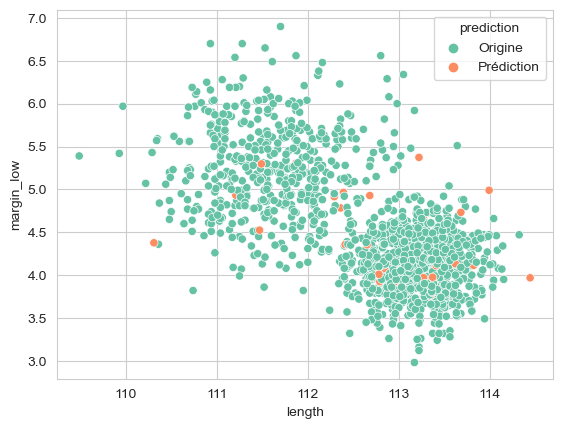

In [188]:
# Afficher les résultats
sns.scatterplot(x='length', y='margin_low', data=df_avec_prediction, hue='prediction', palette='Set2')


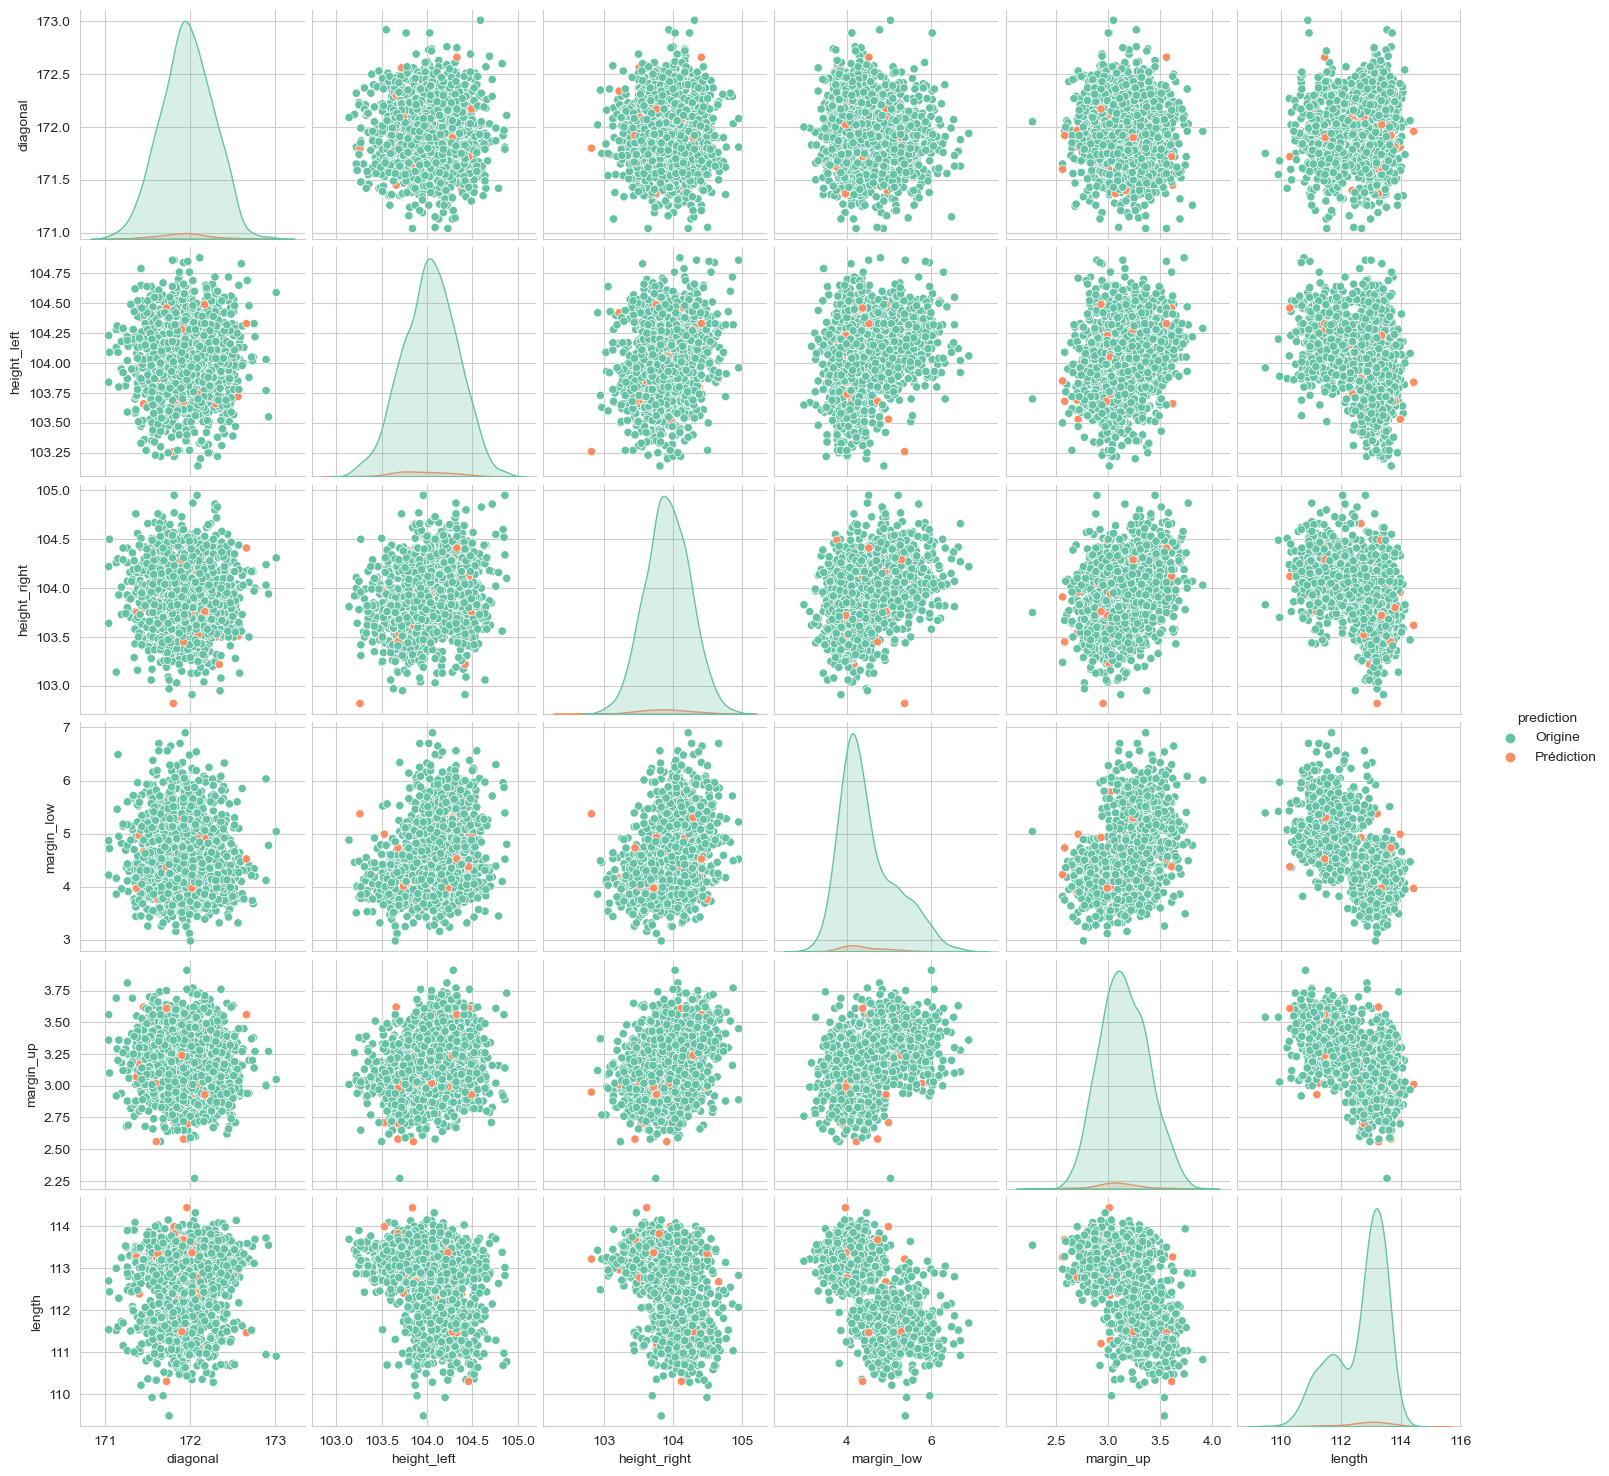

In [189]:
# Afficher les résultats
sns.pairplot(df_avec_prediction.drop(columns='is_genuine'), hue='prediction', palette='Set2')

## Conclusion
On peut voir que les valeurs prédites sont très proches des valeurs originales. On peut donc utiliser le modèle de régression linéaire polynomiale pour prédire les valeurs manquantes de la variable `margin_low`.


# 5 - Modèle de classification

## TrainTest - Nettoyage - Encodage

In [190]:
# copier le dataframe sans la colonne `prediction`
df = df_avec_prediction.drop(columns='prediction').copy()

In [191]:
# Créer les sous-ensembles des vrais billets et des faux billets
true_df = df[df['is_genuine'] == 1]
false_df = df[df['is_genuine'] == 0]

In [192]:
# Remplacer les valeurs True et False par 1 et 0
code = {True : 1, False : 0}
df['is_genuine'] = df['is_genuine'].map(code)

In [193]:
# Créer X et Y
X = df.drop('is_genuine', axis=1)
y = df['is_genuine']

In [194]:
# Créer les sous-ensembles d'entraînement et de test
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [195]:
X_train

diagonal  height_left  height_right  margin_low  margin_up  length
620     171.87       103.40        103.82        4.06       2.94  113.02
655     172.09       104.06        103.90        3.97       3.32  113.09
319     172.05       104.11        104.14        4.73       2.73  113.30
140     172.47       103.82        103.59        3.85       2.77  113.17
629     172.01       104.03        103.67        3.90       3.18  112.61
...        ...          ...           ...         ...        ...     ...
763     172.41       104.43        103.65        3.97       3.35  113.71
835     172.15       104.08        104.10        4.34       2.78  113.33
1216    171.93       104.09        104.51        4.87       3.58  111.63
559     172.12       103.59        103.77        3.74       3.21  113.32
684     172.13       103.76        103.85        3.65       3.24  112.92

[1200 rows x 6 columns]

In [196]:
y_train

620     1
655     1
319     1
140     1
629     1
       ..
763     1
835     1
1216    0
559     1
684     1
Name: is_genuine, Length: 1200, dtype: int64

In [197]:
# Créer les sous-ensembles d'entraînement et de test
trainset = pd.concat([X_train, y_train], axis=1)
testset = pd.concat([X_test, y_test], axis=1)

In [198]:
# taille du testset
testset.shape

(300, 7)

In [199]:
# Pourcentage de vrais billets dans le trainset
trainset['is_genuine'].value_counts(normalize=True)

1    0.664167
0    0.335833
Name: is_genuine, dtype: float64

In [200]:
# Pourcentage de vrais billets dans le testset
testset['is_genuine'].value_counts(normalize=True)

1    0.676667
0    0.323333
Name: is_genuine, dtype: float64

On peut voir que les pourcentages de vrais billets dans les deux sous-ensembles sont très proches. On peut donc utiliser ces sous-ensembles pour entraîner et tester le modèle de classification.

## Modèle de classification
### Régression logistique

In [201]:
# Créer le modèle de régression logistique
model_LogisticRegression = LogisticRegression(random_state=0, max_iter=500)

#### Procédure d'évaluation

In [202]:
# fonction d'évaluation
def evaluation(model):
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    model.fit(X_train, y_train)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))

    n, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='f1', train_sizes=np.linspace(0.1, 1, 100))
    plt.figure(figsize=(12, 8))
    sns.lineplot(x= n, y = train_score.mean(axis=1), label='train')
    sns.lineplot(x= n, y = val_score.mean(axis=1), label='validation')
    plt.show()



[[ 96   1]
 [  1 202]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        97
           1       1.00      1.00      1.00       203

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



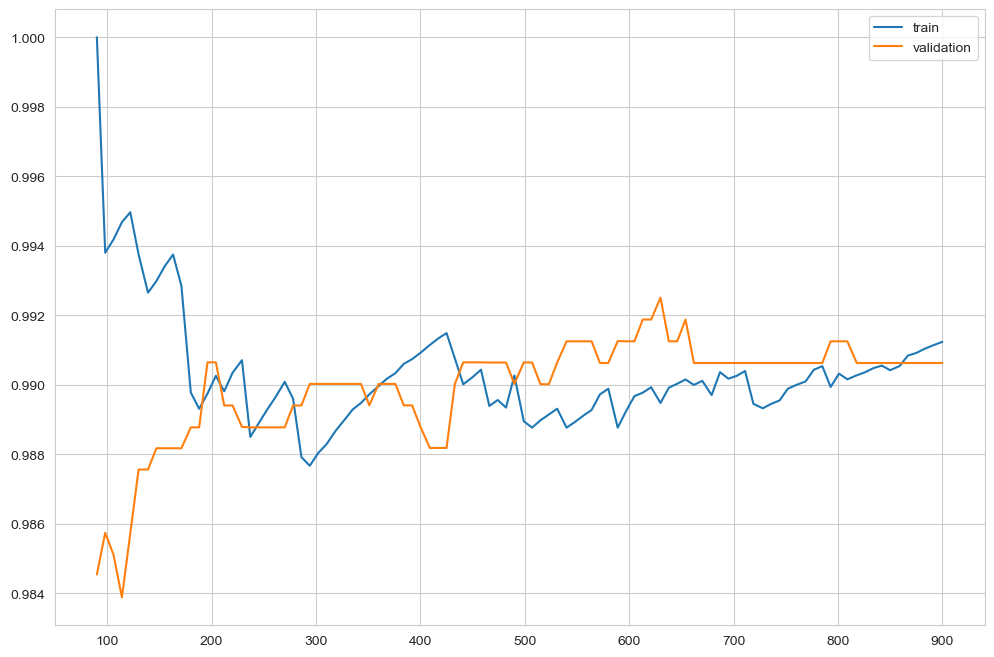

In [203]:
evaluation(model_LogisticRegression)

In [204]:
# indice de performance
model_LogisticRegression.score(X_test, y_test)


0.9933333333333333

### Arbre de décision

In [205]:
# Créer le modèle de l'arbre de décision
model_DecisionTreeClassifier = DecisionTreeClassifier(random_state=0)

#### Procédure d'évaluation

[[ 95   2]
 [  5 198]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        97
           1       0.99      0.98      0.98       203

    accuracy                           0.98       300
   macro avg       0.97      0.98      0.97       300
weighted avg       0.98      0.98      0.98       300



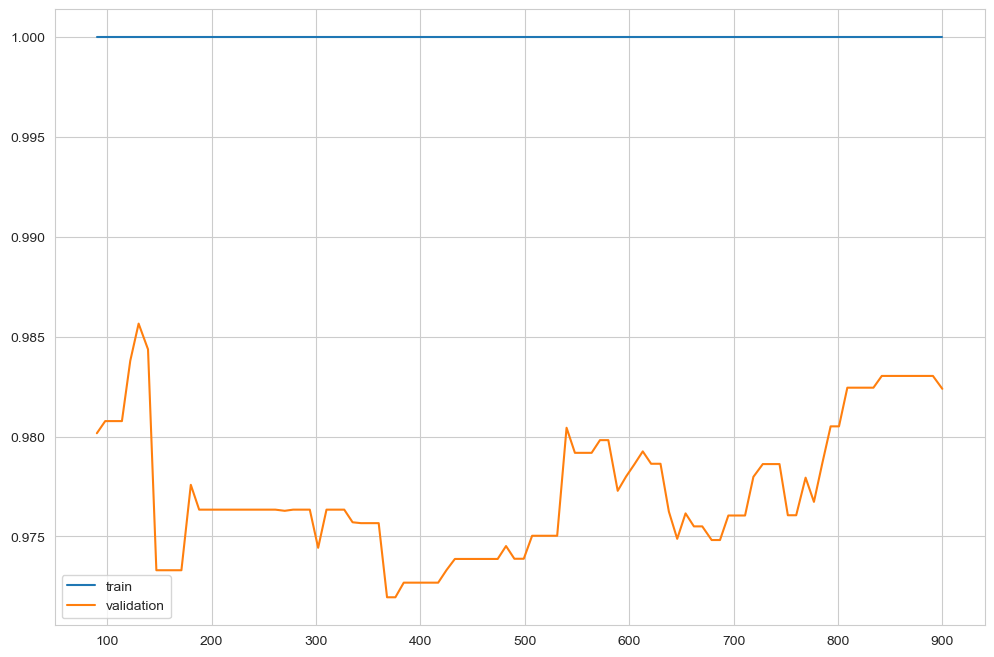

In [206]:
evaluation(model_DecisionTreeClassifier)

### k-means


In [207]:
# Créer le modèle de k-means
model_KMeans = KMeans(n_clusters=2, random_state=0)

In [208]:
model_KMeans.fit(X_train)

KMeans(n_clusters=2, random_state=0)

In [209]:
model_KMeans.cluster_centers_

array([[171.981     , 103.94987654, 103.8105679 ,   4.12636829,
          3.05702469, 113.1924321 ],
       [171.89015385, 104.19628205, 104.14628205,   5.24395464,
          3.34415385, 111.59464103]])

In [210]:
ypred = model_KMeans.fit_predict(X_test)


In [211]:
print(confusion_matrix(y_test, ypred))

[[ 94   3]
 [  1 202]]


In [212]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        97
           1       0.99      1.00      0.99       203

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



## Conclusion et choix du modèle

On peut voir que le modèle de régression logistique est le meilleur modèle pour ce jeu de données. Il a un meilleur indice de performance et un meilleur score F1. On va donc utiliser le modèle de régression logistique pour prédire les valeurs manquantes de la variable `is_genuine`.


On peut voir que le modèle de régression logistique a un score F1 de 0.99 (0.98 pour le Kmeans et 0.96 pour l'arbre de décision). Cela signifie que le modèle est très performant.
Si on compare les scores F1 des trois modèles de classification, on peut voir que le modèle de régression logistique est légèrement meilleur que les modèles de Kmeans et d'arbre de décisions.

Pour le modèle de régression logistique :
- le nombre de vrais billets prédits comme faux billets est de 1/97 (faux positif)
- le nombre de faux billets prédits comme vrais billets est de 1/203 (faux négatif)

Pour le modèle de l'arbre de décision :
- le nombre de vrais billets prédits comme faux billets est de 2/97 (faux positif)
- le nombre de faux billets prédits comme vrais billets est de 5/203 (faux négatif)

Pour le modèle de Kmeans :
- le nombre de vrais billets prédits comme faux billets est de 3/97 (faux positif)
- le nombre de faux billets prédits comme vrais billets est de 1/203 (faux négatif)



Les modèles kmeans et l'arbre de décision ont tendance à prédire plus de faux positifs que le modèle de régression logistique. On va donc utiliser le modèle de régression logistique.

## Sauvegarder le modèle


In [213]:
import pickle

filename = 'model_LogisticRegression.sav'
pickle.dump(model_LogisticRegression, open(filename, 'wb'))